In [2]:
# =====================================================
# 🔬 COMPARACIÓN ENTRE SISTEMA EXPERTO Y RED NEURONAL
# Simulación: Decisiones de un caldero industrial
# Autor: [Tu nombre]
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random

In [5]:
# -----------------------------------------------------
# 1️⃣ SIMULACIÓN DE DATOS
# -----------------------------------------------------

np.random.seed(42)
n = 1000

productos = ["leche", "pasta", "agua"]
objetivos = ["calentar", "hervir", "mantener"]

def simular_datos(n=500):
    data = []
    for _ in range(n):
        temp = np.random.uniform(60, 110)
        pres = np.random.uniform(95, 115)
        nivel = np.random.uniform(50, 100)
        prod = random.choice(productos)
        obj = random.choice(objetivos)
        data.append([temp, pres, nivel, prod, obj])
    return pd.DataFrame(data, columns=["temperatura", "presion", "nivel_liquido", "producto", "objetivo"])

df = simular_datos(n)
print(df.shape)
df.head()

(1000, 5)


,temperatura,presion,nivel_liquido,producto,objetivo
0,78.727006,114.014286,86.599697,leche,mantener
1,89.932924,98.120373,57.799726,agua,mantener
2,62.904181,112.323523,80.055751,pasta,hervir
3,95.403629,95.411690,98.495493,pasta,calentar
4,101.622132,99.246782,59.091248,pasta,mantener


In [6]:
# -----------------------------------------------------
# 2️⃣ SISTEMA EXPERTO SIMBÓLICO
# -----------------------------------------------------

def sistema_experto(row):
    t, p, n, prod, obj = row

    # Reglas simbólicas simples
    if prod == "leche":
        if t > 95:
            return "alerta"
        elif t < 85 and obj == "hervir":
            return "encender"
        else:
            return "mantener"

    elif prod == "pasta":
        if t > 105:
            return "apagar"
        elif obj == "hervir" and t < 95:
            return "encender"
        else:
            return "mantener"

    elif prod == "agua":
        if t > 100:
            return "apagar"
        elif t < 80 and obj == "calentar":
            return "encender"
        else:
            return "mantener"

df["decision_experto"] = df.apply(sistema_experto, axis=1)

In [7]:
df['decision_experto'].value_counts()

,count
decision_experto,
mantener,627
encender,162
alerta,115
apagar,96


In [8]:
# -----------------------------------------------------
# 3️⃣ ENTRENAMIENTO DE RED NEURONAL
# -----------------------------------------------------

# Convertir categóricas a numéricas
df_enc = df.copy()
le_prod = LabelEncoder()
le_obj = LabelEncoder()
le_dec = LabelEncoder()

df_enc["producto"] = le_prod.fit_transform(df_enc["producto"])
df_enc["objetivo"] = le_obj.fit_transform(df_enc["objetivo"])
df_enc["decision_experto"] = le_dec.fit_transform(df_enc["decision_experto"])

X = df_enc[["temperatura", "presion", "nivel_liquido", "producto", "objetivo"]]
y = df_enc["decision_experto"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Red neuronal simple
model = MLPClassifier(hidden_layer_sizes=(12, 6), max_iter=800, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

In [9]:
# -----------------------------------------------------
# 3️⃣ ENTRENAMIENTO DE RED NEURONAL (con ruido)
# -----------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier

# --- Copia base ---
df_enc_noisy = df_enc.copy()

# 🔸 Introducir ruido en las etiquetas (10%)
noise_fraction = 0.10
n_noisy = int(len(df_enc_noisy) * noise_fraction)

indices = np.random.choice(df_enc_noisy.index, n_noisy, replace=False)
df_enc_noisy.loc[indices, "decision_experto"] = np.random.choice(
    df_enc_noisy["decision_experto"].unique(), size=n_noisy
)

# --- Preparar datos ---
X = df_enc_noisy[["temperatura", "presion", "nivel_liquido", "producto", "objetivo"]]
y = df_enc_noisy["decision_experto"]

# Dividir en entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 🔸 Agregar ruido gaussiano a las variables de entrada (ruido sensorial)
noise_input = np.random.normal(0, 0.3, X_train.shape)
X_train_noisy = X_train + noise_input

# --- Entrenar red neuronal ---
model = MLPClassifier(hidden_layer_sizes=(12, 6), max_iter=800, random_state=42)
model.fit(X_train_noisy, y_train)

# Predicciones
y_pred = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
pd.Series(y_pred).value_counts()

,count
3,194
2,56
0,32
1,18


=== Reporte de clasificación (comparando con sistema experto) ===
              precision    recall  f1-score   support

      alerta       0.81      0.72      0.76        36
      apagar       0.89      0.57      0.70        28
    encender       0.82      0.82      0.82        56
    mantener       0.87      0.93      0.90       180

    accuracy                           0.85       300
   macro avg       0.85      0.76      0.80       300
weighted avg       0.85      0.85      0.85       300



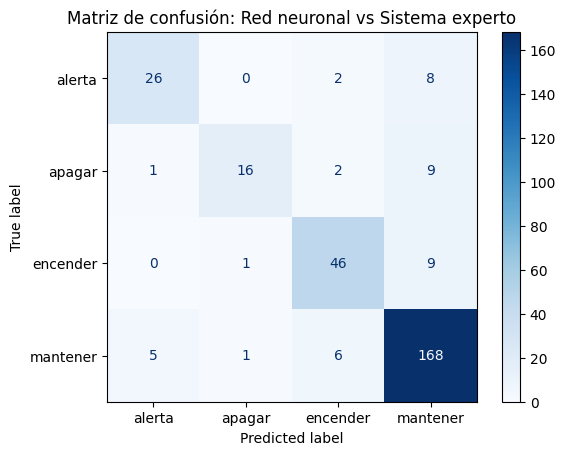

In [13]:
# -----------------------------------------------------
# 4️⃣ EVALUACIÓN Y VISUALIZACIÓN
# -----------------------------------------------------

print("=== Reporte de clasificación (comparando con sistema experto) ===")
print(classification_report(y_test, y_pred, target_names=le_dec.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_dec.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión: Red neuronal vs Sistema experto")
plt.show()

In [15]:
df.columns

Index(['temperatura', 'presion', 'nivel_liquido', 'producto', 'objetivo',
       'decision_experto'],
      dtype='object')

In [16]:
df['objetivo'].value_counts()

,count
objetivo,
hervir,336
calentar,334
mantener,330


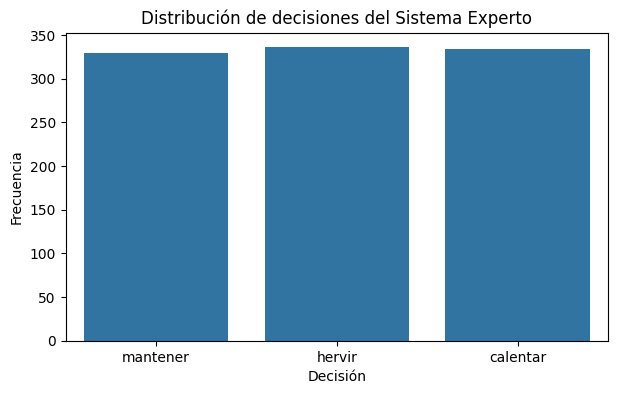

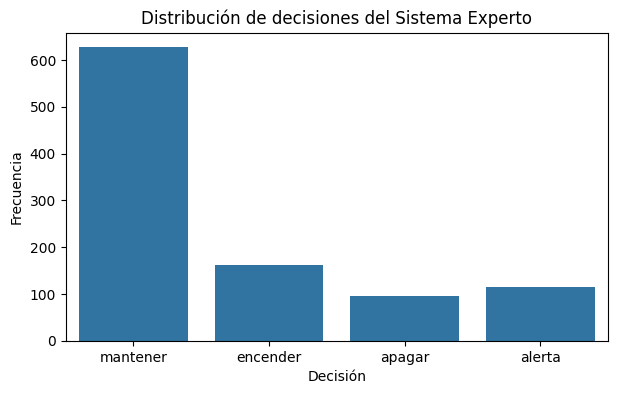

🔍 Ejemplo de comparaciones entre sistemas:


,count
igual,
True,43
False,7


In [18]:
# -----------------------------------------------------
# 5️⃣ ANÁLISIS VISUAL DE DECISIONES
# -----------------------------------------------------

plt.figure(figsize=(7,4))
sns.countplot(x="objetivo", data=df)
plt.title("Distribución de decisiones del Sistema Experto")
plt.xlabel("Decisión")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(7,4))
sns.countplot(x="decision_experto", data=df)
plt.title("Distribución de decisiones del Sistema Experto")
plt.xlabel("Decisión")
plt.ylabel("Frecuencia")
plt.show()

# Comparar algunas predicciones reales
comparacion = pd.DataFrame({
    "Temperatura": X_test[:,0],
    "Presion": X_test[:,1],
    "Nivel": X_test[:,2],
    "Decision_Experto": le_dec.inverse_transform(y_test),
    "Decision_Red": le_dec.inverse_transform(y_pred)
}).sample(50, random_state=42)

print("🔍 Ejemplo de comparaciones entre sistemas:")
comparacion['igual'] = comparacion['Decision_Experto'] == comparacion['Decision_Red']
display(comparacion['igual'].value_counts())